In [64]:
from datasets import load_dataset
import itertools
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [2]:
tweets = load_dataset('stanfordnlp/sentiment140')
tweets

/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for stanfordnlp/sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/stanfordnlp/sentiment140
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 1600000
    })
    test: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 498
    })
})

In [3]:
lab_to_sentiment = {0: 0, 4: 1}

def label_decoder(label):
    return lab_to_sentiment[label]

tweets['train'] = tweets['train'].add_column('label_name', pd.DataFrame(tweets['train'])['sentiment'].apply(lambda x: label_decoder(x)))

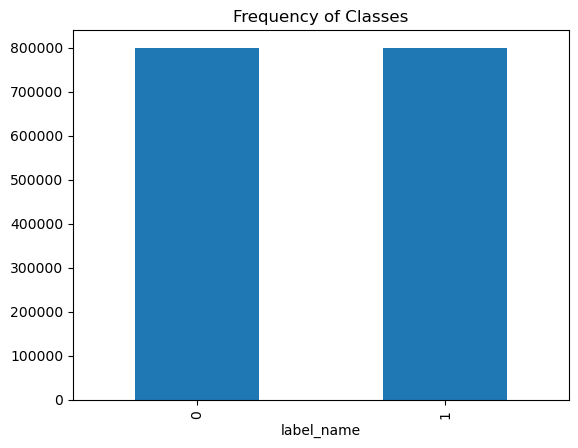

In [4]:
df = pd.DataFrame(tweets['train'])
df['label_name'].value_counts(ascending=True).plot.bar()
plt.title('Frequency of Classes')
plt.show()

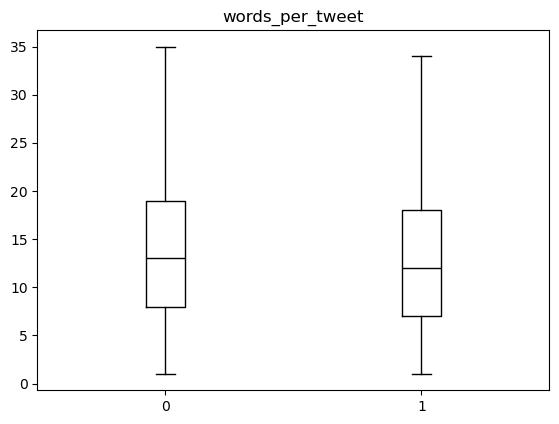

In [5]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('words_per_tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [6]:
lemmatizer = WordNetLemmatizer()
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
separate_numbers_re = '(?<=[a-zA-Z])(?=\d)|(?<=\d)(?=[a-zA-Z])'

In [7]:
def _preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = re.sub(separate_numbers_re, ' ', text)
    tokens = []

    for token in text.split():
        tokens.append(lemmatizer.lemmatize(token))
    
    return ' '.join(tokens)

In [8]:
df.text = df.text.apply(lambda x: _preprocess(x))
df

,text,date,user,sentiment,query,label_name,words_per_tweet
0,awww that s a bummer you shoulda got david car...,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY,0,19
1,is upset that he can t update his facebook by ...,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY,0,21
2,i dived many time for the ball managed to save...,Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY,0,18
3,my whole body feel itchy and like it on fire,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY,0,10
4,no it s not behaving at all i m mad why am i h...,Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY,0,21
...,...,...,...,...,...,...,...
1599995,just woke up having no school is the best feel...,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,4,NO_QUERY,1,11
1599996,thewdb com very cool to hear old walt interview,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,4,NO_QUERY,1,11
1599997,are you ready for your mojo makeover ask me fo...,Tue Jun 16 08:40:49 PDT 2009,bpbabe,4,NO_QUERY,1,11
1599998,happy 38 th birthday to my boo of alll time tu...,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,4,NO_QUERY,1,12


In [60]:
TRAIN_SIZE = 0.8
train_data, test_data = train_test_split(df[['text', 'label_name']], train_size=TRAIN_SIZE, random_state=7)
x_train, y_train, x_test, y_test = np.array(train_data['text']), np.array(train_data['label_name']), np.array(test_data['text']), np.array(test_data['label_name'])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1280000,) (1280000,) (320000,) (320000,)


In [61]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [62]:
x_train = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=35, return_tensors='tf')
x_test = tokenizer(list(x_test), truncation=True, padding='max_length', max_length=35, return_tensors='tf')

x_train, x_test = x_train['input_ids'], x_test['input_ids']

print(x_train.shape, x_test.shape)

(1280000, 35) (320000, 35)


In [66]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [67]:
loss = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer, metrics=SparseCategoricalAccuracy(), loss=loss)

In [68]:
BATCH_SIZE = 64
EPOCHS = 1

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test))

2024-09-23 14:09:47.256442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


20000/20000 [==============================] - ETA: 0s - loss: 0.3638 - sparse_categorical_accuracy: 0.8377

2024-09-23 16:17:25.823027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


KeyboardInterrupt: 

In [69]:
scores = model.predict(x_test, verbose=1, batch_size=BATCH_SIZE)
y_pred_1d = [np.argmax(score) for score in scores.logits]

2024-09-23 16:23:58.886928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


5000/5000 [==============================] - 423s 84ms/step


In [70]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

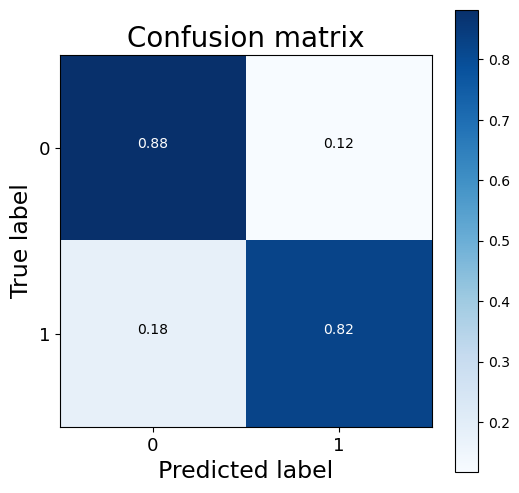

In [71]:
cnf_matrix = confusion_matrix(test_data.label_name.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.label_name.unique(), title="Confusion matrix")
plt.show()

In [72]:
print(classification_report(list(test_data.label_name), y_pred_1d))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86    160542
           1       0.87      0.82      0.85    159458

    accuracy                           0.85    320000
   macro avg       0.85      0.85      0.85    320000
weighted avg       0.85      0.85      0.85    320000

